# Importing Necessary libraries and dataset

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


In [364]:
#Importing the dataset

filepath = r"C:\Users\padma\Desktop\Computer_Science\al-ml\Datasets\diabetes.csv"

data = pd.read_csv(filepath)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Creating Necessary Functions


In [365]:

def hist_for_all(shape,data,column_names, bins = 10):
    rows, columns = shape
    fig, ax = plt.subplots(2,4, figsize = (25,10))
    axes = [ax[i][j] for i in range(rows) for j in range(columns)]

    for pos, column in enumerate(column_names):
        axes[pos].hist(data[column], bins = bins)
        axes[pos].set_title(column)
    
    plt.show()

def IQR(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    upper_whisker = q3 + 1.5*iqr
    lower_whisker = q1 - 1.5*iqr

    return upper_whisker, lower_whisker


def classification_metrics(y_test,y_pred):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred))
    print(f'Accuracy Score : {accuracy_score(y_test, y_pred)}')
    print(f'Precision Score : {precision_score(y_test, y_pred)}')
    print(f'Recall Score : {recall_score(y_test, y_pred)}')
    print(f'F1 Score : {f1_score(y_test, y_pred)}')


compare = pd.DataFrame(np.array(['Accuracy Score','Precision Score','Recall Score', 'F1 Score']), columns = ['Metrics'])

def add_to_compare(y_test,y_pred):
    return [accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred)]

# Data Preprocessing

## Analyzing data

In [366]:
#Checking the data stats

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


all the columns are numeric and have 0 in place of null.(except pregnancies)

In [367]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [368]:
data.shape

(768, 9)

### Checking for duplicated rows

In [369]:
data.duplicated().sum()

#No duplicated rows found

0

as 0 is there instead of nan, for better visualisiation of the data, replacing 0 with nan (except pregnancies AND Outcome columns)

In [427]:
data.iloc[:,1:-1] = data.iloc[:,1:-1].map(lambda x: np.nan if x == 0 or x == 0.0 else x)

bool_df = data == 0

bool_df.sum()

#So all the 0s which was considered nan is replaced with nan. Now only pregnancies and outcome columns has zeroes.


Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [371]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [372]:
data.shape

(768, 9)

In [373]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
Glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
BloodPressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
SkinThickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
Insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
BMI,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
DiabetesPedigreeFunction,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
Age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
Outcome,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


<Axes: >

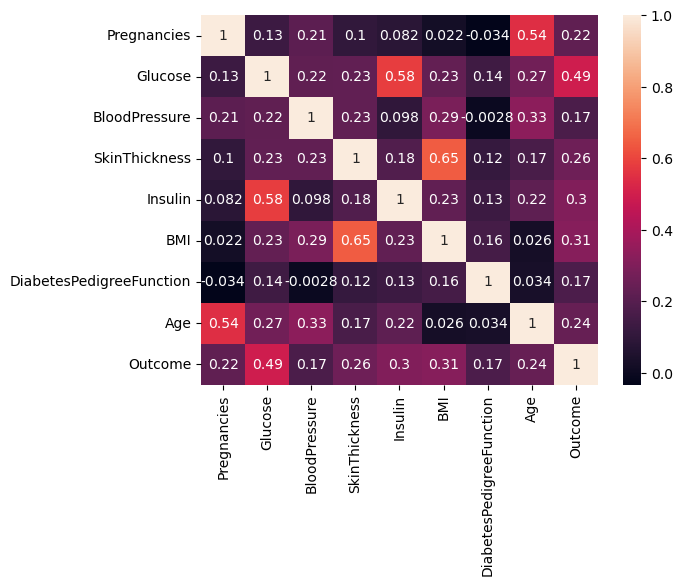

In [374]:
sns.heatmap(data.corr(), annot = True)

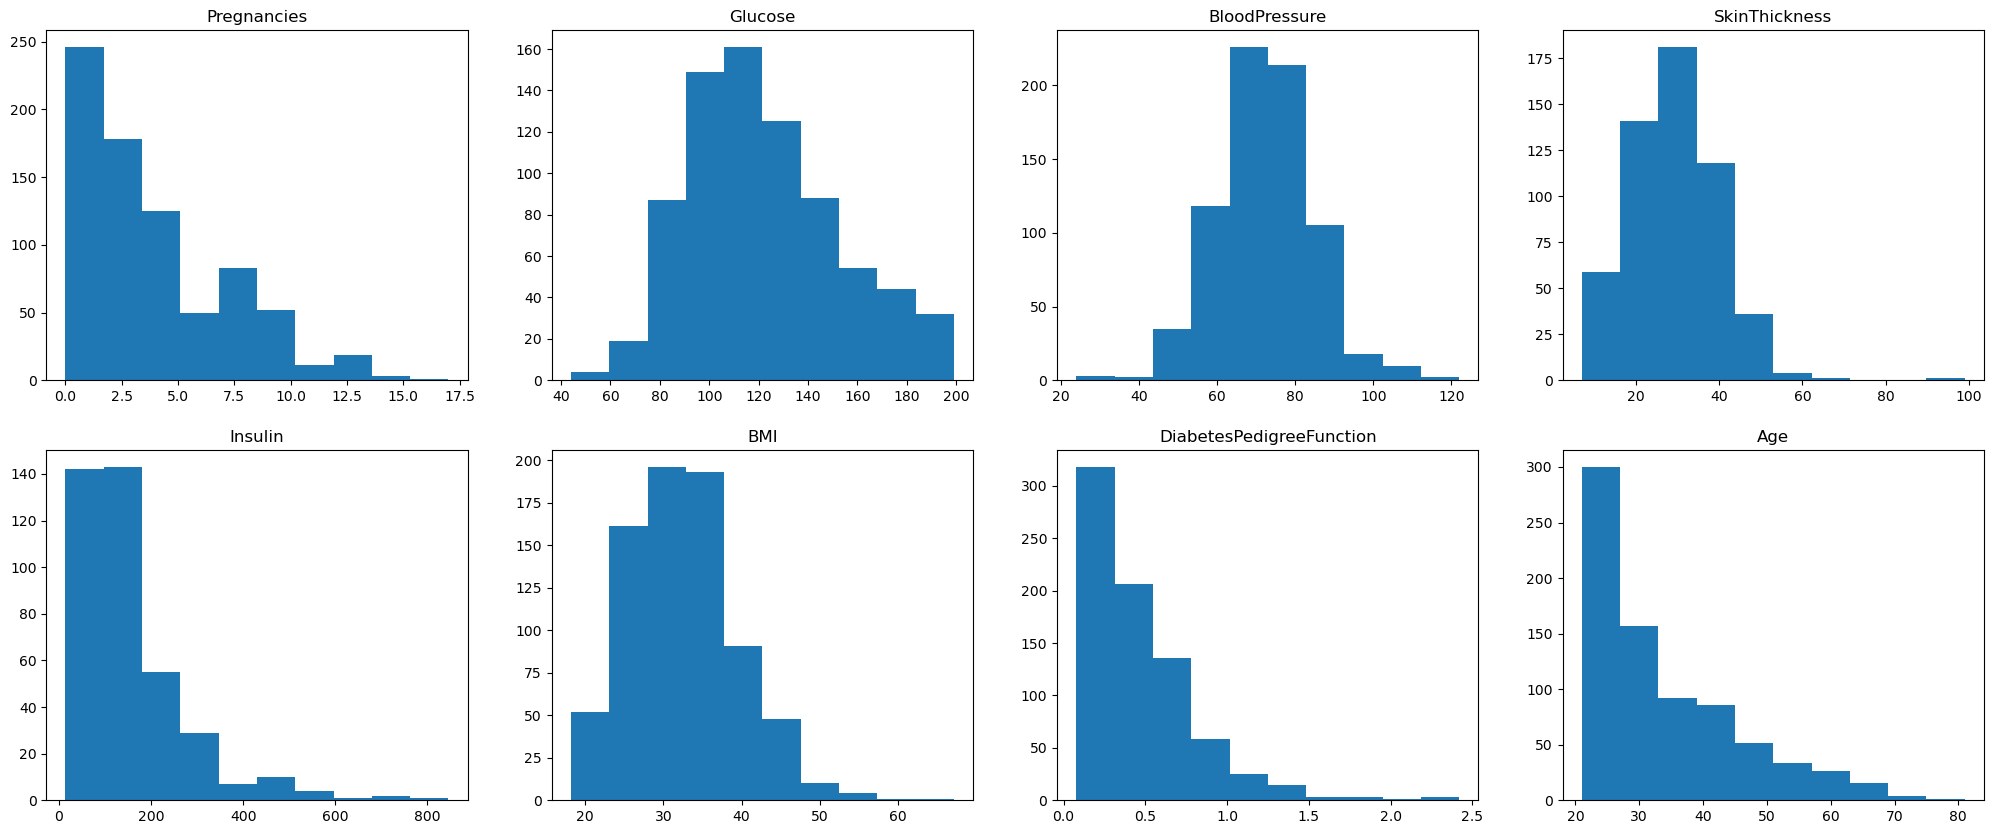

In [375]:
hist_for_all(shape=(2,4), data=data, column_names= data.drop('Outcome', axis = 1).columns)


Considering the above graphs, blood pressure, skin thickness (nearly) , BMI(nearly) are normally distributed and the rest are positively skewed.

## Outlier Detection

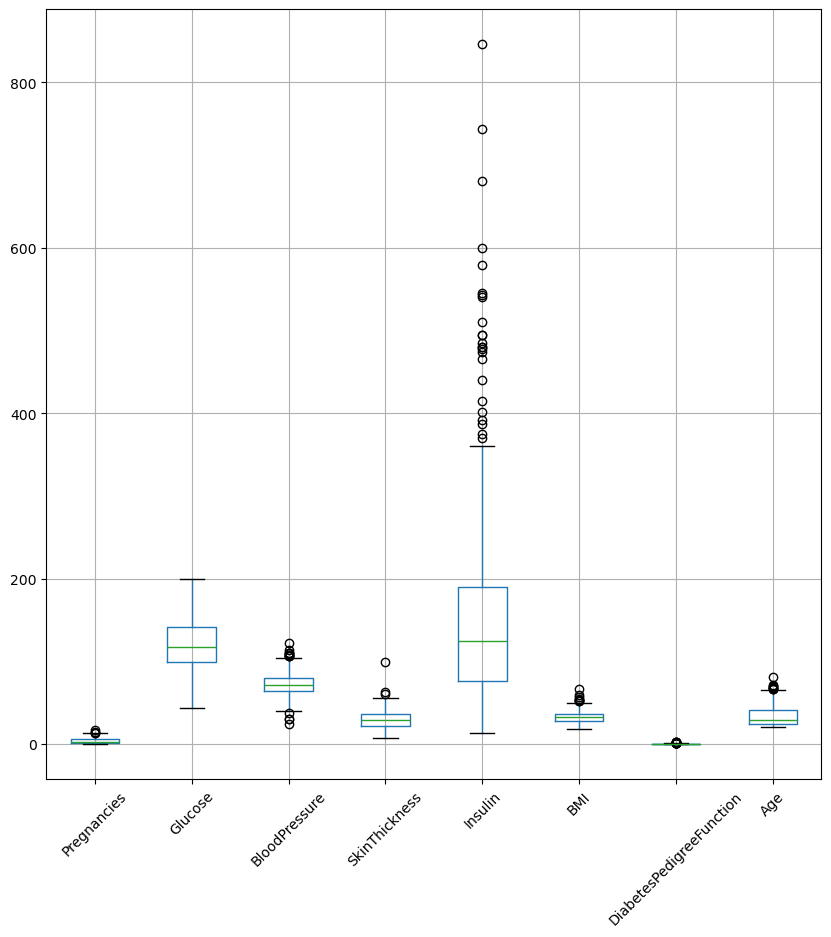

In [376]:
# Boxplot for detecting outliers
plt.figure(figsize=(10,10))
data.drop('Outcome', axis = 1).boxplot()
plt.xticks(rotation = 45)
plt.show()



In [377]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Detailed Analysis

+ Pregnancies
  + It has a min of 0 and a max of 17 (which should be an anomaly) as the 3rd Quartile value is only 6.
  + even considering the older generations, pregnancies > 11 feels to be an error. -- So some outliers need to be removed.
  + The histogram shows a positively skewed data, as it should be because people with higher number of pregnancies become lesser.

+ Glucose
  + Glucose levels have no outliers in the boxplot
  + The  min is 44 and max is 199 which is the the range of glucose levels.
  + It has a little skewed distribution.

+ Blood Pressure
  + Normally distributed
  + Usually bp is indicated by a pair of numbers, and in the data it is represnted by only one number.
  + Since it is a vital health data and the min and max values are in the range, the outliers are not to be removed.

+ Skin Thickness
  + Nearly normally distributed.
  + Considering the boxplot, only the max value 90 is more distant from the 3rd Quartile - 36.
  + Some values very far from 36 to be removed.

+ Insulin
  + Considering the min value 14, max value 846 and the quartiles, assuming that the data is in pmol/L units.
  + In that unit the range of values are ok and need not be considered as outliers.
  + As insulin levels are a vital data and have varied values in different people, outliers are not removed.

+ BMI
  + BMI > 40 is considere severly obese and the data have values above 50 and 60-- so outliers need to be checked.

+ DiabetesPedigreeFunction
  +  The values are in the normal range of diabetespedigree function.

+ Age 
  + Age has a min of 21 and max of 81 and the outliers are relevent as it represents a unique age.
  + But the histogram shows a positively skewed data, implying that the data set represents more of younger generation.
  

Using log transformation for further outlier detection.

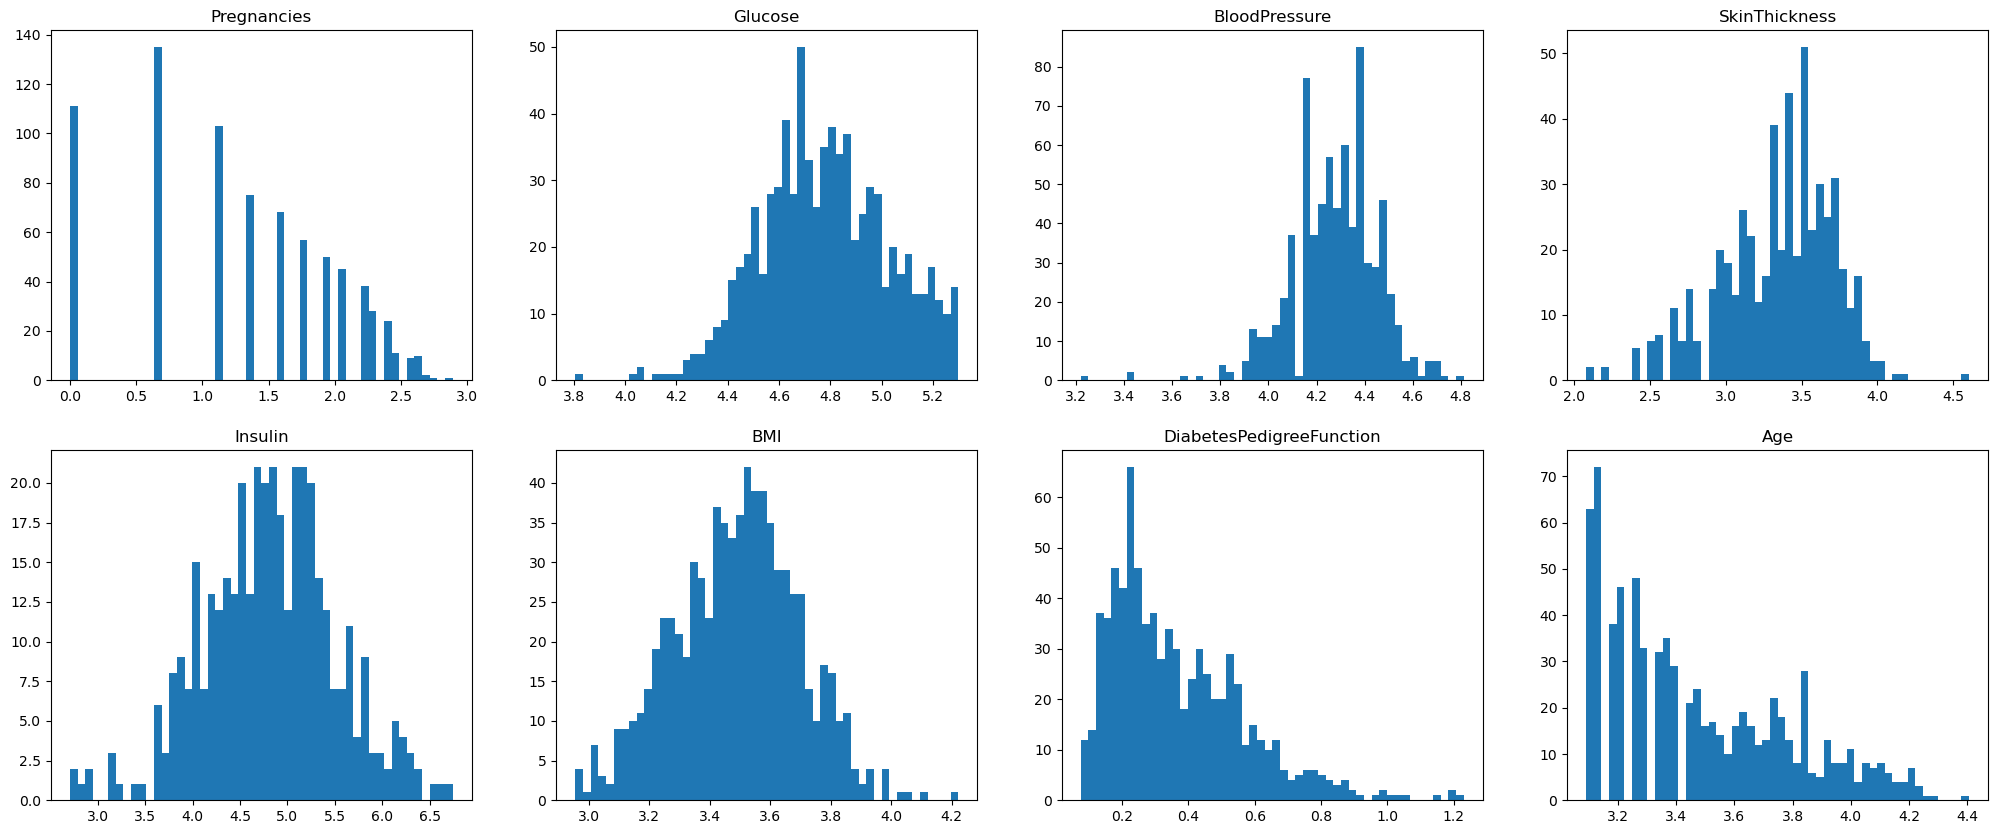

In [378]:
log_data = np.log(data+1)

hist_for_all((2,4), column_names= data.drop('Outcome', axis = 1).columns, data= log_data, bins = 50)

No further outlier information got from the graphs.

#### Pregnancies

In [379]:
#Checking for values > 8
data[data['Pregnancies'] > 8]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
11,10,168.0,74.0,NaN,NaN,38.0,0.537,34,1
12,10,139.0,80.0,NaN,NaN,27.1,1.441,57,0
23,9,119.0,80.0,35.0,NaN,29.0,0.263,29,1
24,11,143.0,94.0,33.0,146.0,36.6,0.254,51,1
...,...,...,...,...,...,...,...,...,...
744,13,153.0,88.0,37.0,140.0,40.6,1.174,39,0
745,12,100.0,84.0,33.0,105.0,30.0,0.488,46,0
761,9,170.0,74.0,31.0,NaN,44.0,0.403,43,1
762,9,89.0,62.0,NaN,NaN,22.5,0.142,33,0


In [380]:
#Considering the number of pregnancies and the corresponding age, most of these above values feels like there is error in in it.

#so , filering out the rows with a higher prenancy and lower age.
data.loc[(data['Age'] < 45) & (data['Pregnancies'] > 9)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
11,10,168.0,74.0,NaN,NaN,38.0,0.537,34,1
25,10,125.0,70.0,26.0,115.0,31.1,0.205,41,1
36,11,138.0,76.0,NaN,NaN,33.2,0.420,35,0
72,13,126.0,90.0,NaN,NaN,43.4,0.583,42,1
88,15,136.0,70.0,32.0,110.0,37.1,0.153,43,1
143,10,108.0,66.0,NaN,NaN,32.4,0.272,42,1
193,11,135.0,NaN,NaN,NaN,52.3,0.578,40,1
215,12,151.0,70.0,40.0,271.0,41.8,0.742,38,1
246,10,122.0,68.0,NaN,NaN,31.2,0.258,41,0


In [381]:
#Chahnging the value to the median of the data, as it was not a normaly distributed data.
data.loc[(data['Age'] < 45) & (data['Pregnancies'] > 9), "Pregnancies"] = data['Pregnancies'].median()

In [382]:
#Also capping the extreme values to the median( upper whisker is not taken as it is nearly 14)

data.loc[data['Pregnancies'] > 12, 'Pregnancies'] = data['Pregnancies'].median()

#### Skin Thickness

In [383]:
up, low = IQR(data['SkinThickness'])

up, low

(57.0, 1.0)

In [384]:
#Capping the extreme values to the upperwhisker
data[(data['SkinThickness'] > 57) |(data['SkinThickness'] <1)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
57,0,100.0,88.0,60.0,110.0,46.8,0.962,31,0
445,0,180.0,78.0,63.0,14.0,59.4,2.420,25,1
579,2,197.0,70.0,99.0,NaN,34.7,0.575,62,1


In [385]:
# Since the other 2 values except 99 are near to upper whisker, we are not changing it.
data.loc[579, 'SkinThickness'] = up

## Handling Missing Values

In [386]:
data.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [387]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


As all columns are numerical, using knn imputer to impute the missing values.

In [388]:
imputer = KNNImputer(missing_values= np.nan, n_neighbors=5)
data1 =imputer.fit_transform(data)

In [389]:
data = pd.DataFrame(data1, columns= imputer.get_feature_names_out())

In [390]:
data.isna().sum()
#so all the nan values have been filled.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Feature Target Split

In [391]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

## Train Test Split

In [392]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state= 42, test_size= 0.2)

## Feature Scaling

In [393]:
minmax = MinMaxScaler()

x_train_minmax = minmax.fit_transform(x_train)
x_test_minmax = minmax.transform(x_test)

In [394]:
sc = StandardScaler()

x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

In [395]:
rc = RobustScaler()

x_train_rc = rc.fit_transform(x_train)
x_test_rc = rc.transform(x_test)

# Logistic Regression

In [396]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()

In [397]:
# with minmax scaled data
log.fit(x_train_minmax,y_train)
y_pred_minmax = log.predict(x_test_minmax)
classification_metrics(y_test,y_pred_minmax)

Confusion Matrix:
[[85 14]
 [22 33]]
Accuracy Score : 0.7662337662337663
Precision Score : 0.7021276595744681
Recall Score : 0.6
F1 Score : 0.6470588235294118


In [398]:
# with standard scaled data
log.fit(x_train_sc,y_train)
y_pred_sc = log.predict(x_test_sc)
classification_metrics(y_test,y_pred_sc)

Confusion Matrix:
[[84 15]
 [20 35]]
Accuracy Score : 0.7727272727272727
Precision Score : 0.7
Recall Score : 0.6363636363636364
F1 Score : 0.6666666666666666


In [399]:
# with robust scaled data
log.fit(x_train_rc,y_train)
y_pred_rc = log.predict(x_test_rc)
classification_metrics(y_test,y_pred_rc)

Confusion Matrix:
[[84 15]
 [20 35]]
Accuracy Score : 0.7727272727272727
Precision Score : 0.7
Recall Score : 0.6363636363636364
F1 Score : 0.6666666666666666


In [400]:
#here the standard scaled and robust scaled data gives a better result
compare['Logistic Regression'] = add_to_compare(y_test, y_pred_sc)

# KNN classification

In [401]:
from sklearn.neighbors import KNeighborsClassifier


#### Using minmax scaled data

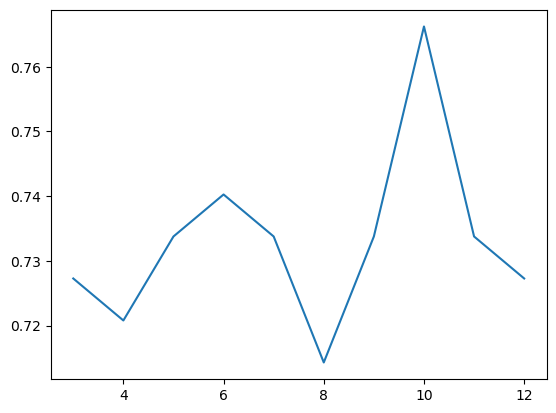

In [402]:
metrics = []
k_values = np.arange(3,13)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(x_train_minmax, y_train)
    y_pred = knn.predict(x_test_minmax)
    metrics.append(accuracy_score(y_test,y_pred))

plt.plot(k_values, metrics)
plt.show()

In [403]:
knn = KNeighborsClassifier(n_neighbors= 10)
knn.fit(x_train_minmax, y_train)
y_pred_minmax = knn.predict(x_test_minmax)

classification_metrics(y_test, y_pred_minmax)


Confusion Matrix:
[[85 14]
 [22 33]]
Accuracy Score : 0.7662337662337663
Precision Score : 0.7021276595744681
Recall Score : 0.6
F1 Score : 0.6470588235294118


#### With Standard scaled data

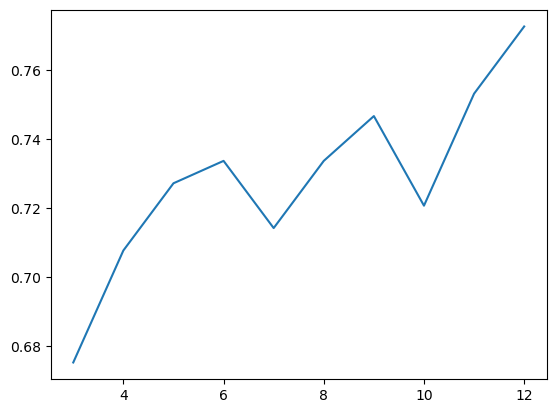

In [404]:
metrics = []
k_values = np.arange(3,13)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(x_train_sc, y_train)
    y_pred = knn.predict(x_test_sc)
    metrics.append(accuracy_score(y_test,y_pred))

plt.plot(k_values, metrics)
plt.show()

In [405]:
knn = KNeighborsClassifier(n_neighbors= 12)
knn.fit(x_train_sc, y_train)
y_pred_sc = knn.predict(x_test_sc)

classification_metrics(y_test, y_pred_sc)

Confusion Matrix:
[[85 14]
 [21 34]]
Accuracy Score : 0.7727272727272727
Precision Score : 0.7083333333333334
Recall Score : 0.6181818181818182
F1 Score : 0.6601941747572816


#### With robust scaled data

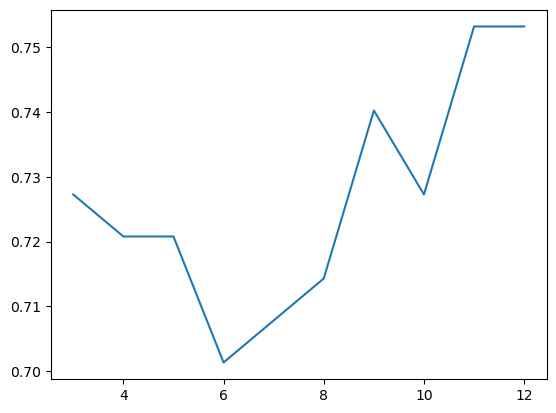

In [406]:
metrics = []
k_values = np.arange(3,13)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(x_train_rc, y_train)
    y_pred = knn.predict(x_test_rc)
    metrics.append(accuracy_score(y_test,y_pred))

plt.plot(k_values, metrics)
plt.show()

In [407]:
knn = KNeighborsClassifier(n_neighbors= 11)
knn.fit(x_train_rc, y_train)
y_pred_rc = knn.predict(x_test_rc)

classification_metrics(y_test, y_pred_rc)

Confusion Matrix:
[[79 20]
 [18 37]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6491228070175439
Recall Score : 0.6727272727272727
F1 Score : 0.6607142857142857


In [408]:
#Here standard scaling gives a better result.
compare['KNN'] = add_to_compare(y_test, y_pred_sc)

# SVM Classification

In [409]:
from sklearn.svm import SVC

svc = SVC(kernel= 'linear')  #Here kernel-- linear is giving better results


In [410]:
#With minmax data
svc.fit(x_train_minmax,y_train)

y_pred_minmax = svc.predict(x_test_minmax)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[84 15]
 [23 32]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6808510638297872
Recall Score : 0.5818181818181818
F1 Score : 0.6274509803921569


In [411]:
#with Standard scaled data

svc.fit(x_train_sc,y_train)

y_pred_sc = svc.predict(x_test_sc)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[84 15]
 [23 32]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6808510638297872
Recall Score : 0.5818181818181818
F1 Score : 0.6274509803921569


In [412]:
#With Robust scaled data
svc.fit(x_train_rc,y_train)

y_pred_rc = svc.predict(x_test_rc)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[84 15]
 [23 32]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6808510638297872
Recall Score : 0.5818181818181818
F1 Score : 0.6274509803921569


In [413]:
#all 3 are having same results
compare['SVC'] = add_to_compare(y_test, y_pred_sc)

# Naive Bayes Classification

In [414]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [415]:
#With minmax scaled data
nb.fit(x_train_minmax,y_train)
y_pred_minmax = nb.predict(x_test_minmax)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[84 15]
 [23 32]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6808510638297872
Recall Score : 0.5818181818181818
F1 Score : 0.6274509803921569


In [416]:
#With standard scaled data
nb.fit(x_train_sc,y_train)
y_pred_sc = nb.predict(x_test_sc)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[84 15]
 [23 32]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6808510638297872
Recall Score : 0.5818181818181818
F1 Score : 0.6274509803921569


In [417]:
#With robust scaled data
nb.fit(x_train_rc,y_train)
y_pred_rc = nb.predict(x_test_rc)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[84 15]
 [23 32]]
Accuracy Score : 0.7532467532467533
Precision Score : 0.6808510638297872
Recall Score : 0.5818181818181818
F1 Score : 0.6274509803921569


In [419]:
#all the different scaled values are having nearly same results
compare['Naive Bayes'] = add_to_compare(y_test, y_pred_sc)

# Decision Tree Classification

In [466]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 6, max_leaf_nodes= 70)  #entropy criterion is giving better results than others

In [471]:
#With non scaled data
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)

classification_metrics(y_test, y_pred)


Confusion Matrix:
[[74 25]
 [16 39]]
Accuracy Score : 0.7337662337662337
Precision Score : 0.609375
Recall Score : 0.7090909090909091
F1 Score : 0.6554621848739496


In [472]:
#With minmax scaled data
tree.fit(x_train_minmax, y_train)

y_pred_minmax = tree.predict(x_test_minmax)

classification_metrics(y_test, y_pred_minmax)

Confusion Matrix:
[[74 25]
 [14 41]]
Accuracy Score : 0.7467532467532467
Precision Score : 0.6212121212121212
Recall Score : 0.7454545454545455
F1 Score : 0.6776859504132231


In [473]:
#With standard scaled data
tree.fit(x_train_sc, y_train)

y_pred_sc = tree.predict(x_test_sc)

classification_metrics(y_test, y_pred_sc)

Confusion Matrix:
[[74 25]
 [16 39]]
Accuracy Score : 0.7337662337662337
Precision Score : 0.609375
Recall Score : 0.7090909090909091
F1 Score : 0.6554621848739496


In [475]:
#With robust scaled data
tree.fit(x_train_rc, y_train)

y_pred_rc = tree.predict(x_test_rc)

classification_metrics(y_test, y_pred)

Confusion Matrix:
[[74 25]
 [16 39]]
Accuracy Score : 0.7337662337662337
Precision Score : 0.609375
Recall Score : 0.7090909090909091
F1 Score : 0.6554621848739496


In [476]:
#Here standard scaled data is giving better predictions
compare['Decision Tree'] = add_to_compare(y_test,y_pred_sc)

In [477]:
compare

,Metrics,Logistic Regression,KNN,SVC,Naive Bayes,Decision Tree
0,Accuracy Score,0.772727,0.772727,0.772727,0.733766,0.733766
1,Precision Score,0.700000,0.708333,0.708333,0.616667,0.609375
2,Recall Score,0.636364,0.618182,0.618182,0.672727,0.709091
3,F1 Score,0.666667,0.660194,0.660194,0.643478,0.655462


Here clearly, the first 3 model has a better performance.